In [1]:
# =============================================================================
# Import
# =============================================================================

import tensorflow as tf
from keras import backend as K
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pandas as pd
import imageio
from PIL import Image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import time
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from tensorflow.keras.optimizers import SGD
import scipy.io
from skimage.morphology import disk, dilation, erosion, remove_small_objects, remove_small_holes
from skimage.measure import label, regionprops
print('Your imports are available')
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Softmax
import random
import pickle

2023-07-01 00:36:18.072901: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 00:36:18.636281: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Your imports are available


In [2]:
# =============================================================================
# GPU Test
# =============================================================================

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

2023-07-01 00:36:24.080104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 00:36:24.128080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 00:36:24.128272: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
# =============================================================================================
# Main code (2) reading images and lables for train and making images and labels folder
# =============================================================================================

img_folder = r'/home/user/Desktop/MandalPaperCodePython/Data/Blk65x65_Seg/Im' 
label_folder =r'/home/user/Desktop/MandalPaperCodePython/Data/Blk65x65_Seg/Lbs'

# Get list of image and label filenames
img_filenames = sorted(os.listdir(img_folder))
# label_filenames = sorted(os.listdir(label_folder))

# random.seed(42)
# random.shuffle(img_filenames)



# print(img_filenames[:5])    
# print(label_filenames[:5])  
# print(img_filenames[5:15])    
# print(label_filenames[5:15]) 

# Load images and labels into numpy arrays
images = []
labels = []
for i, img_filename in tqdm(enumerate(img_filenames)):
    
    # Load image and resize to 65x65
    img = cv2.imread(os.path.join(img_folder, img_filename))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    #img = cv2.resize(img, (65, 65))
    
    # Load corresponding label and convert to one-hot encoding
    label = cv2.imread(os.path.join(label_folder, img_filename))
    label = cv2.cvtColor(label,cv2.COLOR_BGR2RGB)    
    #label = cv2.resize(label, (65, 65))

    # Append image and label to arrays
    images.append(img)
    labels.append(label) 
#########################################################################
img_folder = r'/home/user/Desktop/MandalPaperCodePython/SavedFiles'
with open("shuffled_filenames.pickle", "wb") as file:
    pickle.dump(img_filenames, file)   
print(img_filenames[:5]) 
print ('Your image folder "images" and your labels foldr "labels" are produced')

36736it [00:07, 4872.51it/s]

['Image1.png', 'Image10.png', 'Image100.png', 'Image1000.png', 'Image10000.png']
Your image folder "images" and your labels foldr "labels" are produced


Image filename: Image28468.png


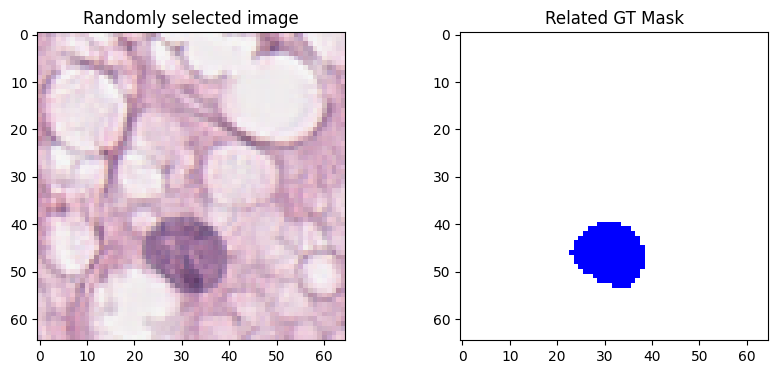

In [4]:
# ===========================================================================================
#  Main code (3) show an image and its mask after imresizing to 65*65, and print pixel values of image and mask   
# ===========================================================================================

image_dataset = np.array(images)
mask_dataset =  np.array(labels)

#Sanity check, view few images
import random
image_number = random.randint(0, len(image_dataset))

# Print corresponding image and label filenames
print("Image filename:", img_filenames[image_number])
# print("Label filename:", label_filenames[image_number])

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Randomly selected image')
plt.imshow(np.reshape(image_dataset[image_number], (65, 65, 3)))
plt.subplot(122)
plt.title('Related GT Mask')
plt.imshow(np.reshape(mask_dataset[image_number], (65, 65,3)))
plt.savefig(r'/home/user/Desktop/MandalPaperCodePython/Results/Im&Mask.jpg',dpi=300)
plt.show()

# Convert the mask array to a list and print it
mask_value = labels[image_number].tolist()
# print(mask_value)    
image_value = image_dataset[image_number].tolist()
# print(image_value)    

In [5]:
# =============================================================================
# Convert RGB Masks to 2D labels (0=Melanoma,1=Non_melanoma,2=Background)
# =============================================================================

#Call "rgb_to_2D_label" function
%run rgb_to_2D_label.ipynb

labels_ctg = []
for i in tqdm(range(mask_dataset.shape[0])):
    label = rgb_to_2D_label(mask_dataset[i])
    labels_ctg.append(label)    

labels_ctg = np.array(labels_ctg)   
labels_ctg = np.expand_dims(labels_ctg, axis=3)

# print number of classes and their values
n_classes = len(np.unique(labels_ctg))
print ("Number of different classes in labels are:", n_classes)
print("Unique values of labels are:", np.unique(labels_ctg))

#Convert to categorical
labels_cat = to_categorical(labels_ctg, num_classes=n_classes)


"rgb_to_2D_label" function is called


100%|███████████████████████████████████| 36736/36736 [00:13<00:00, 2671.38it/s]


Number of different classes in labels are: 3
Unique values of labels are: [0 1 2]


In [6]:
# =============================================================================
# Split the data into train and test sets (70% train, 30% validation & test)
# =============================================================================

# Split the data set into train and (test&validation) sets (70% train, 30% (test&validation)
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.3, random_state=42)

# Split the (test&validation) set into validation and test sets (50% validation, 50% test)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Image heigt=",X_train.shape[1])
print("Image width=",X_train.shape[2])
print("Image channels=",X_train.shape[3])

Image heigt= 65
Image width= 65
Image channels= 3


In [7]:
# =============================================================================
# Defining model
# =============================================================================

#Call model (Unet, DeepCNNmodel_Modified) function
# %run Unet_model.ipynb
%run DeepCNNmodel_Modified.ipynb

model=DeepCNNmodel_Modified()
#model = DeepCNNmodel_Modified_64size(None)
#model = Unet_model_64size()       #64*64 
# model = Unet_model()                #65*65

2023-07-01 00:37:31.633132: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 00:37:31.633529: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-01 00:37:31.633712: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(None, 64, 64, 64) relu1_1 shape after passing conve 2*2
(None, 64, 64, 64) D1_1 shape after passing conve 2*2
(None, 64, 64, 64)
(None, 65, 65, 192)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 I1 (InputLayer)                [(None, 65, 65, 3)]  0           []                               
                                                                                                  
 Conv1_1 (Conv2D)               (None, 65, 65, 64)   1792        ['I1[0][0]']                     
                                                                                                  
 B1_1 (BatchNormalization)      (None, 65, 65, 64)   256         ['Conv1_1[0][0]']                
                                                                                                  
 relu1_1 (Activation)           (None, 65, 

                                                                                                  
 relu2_5 (Activation)           (None, 8, 8, 64)     0           ['B2_5[0][0]']                   
                                                                                                  
 relu1_6 (Activation)           (None, 65, 65, 64)   0           ['B1_6[0][0]']                   
                                                                                                  
 concatenate (Concatenate)      (None, 8, 8, 128)    0           ['relu2_5[0][0]',                
                                                                  'Max2_3[0][0]']                 
                                                                                                  
 Conv1_7 (Conv2D)               (None, 65, 65, 64)   921664      ['relu1_6[0][0]']                
                                                                                                  
 unpool2_3

                                                                  'relu1_1_deshaped_padded[0][0]']
                                                                                                  
 Conv2_class (Conv2D)           (None, 65, 65, 3)    579         ['depthcat_5[0][0]']             
                                                                                                  
 Softmax (Softmax)              (None, 65, 65, 3)    0           ['Conv2_class[0][0]']            
                                                                                                  
Total params: 20,152,067
Trainable params: 20,149,891
Non-trainable params: 2,176
__________________________________________________________________________________________________


In [9]:
# =============================================================================
# Compiling model & Defining callbacks
# =============================================================================

#Call jacard_coef & iou_coef function
%run jacard_coef.ipynb
%run iou_coef.ipynb

metrics=['accuracy', jacard_coef,iou_coef]
opt = SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
# opt = 'adam'

# =============================================================================
# # Compile the model with the manual above defined metrics
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=metrics)
# metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=3)])

# =============================================================================
# # Define callbacks

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_lr=0.00001)
model_checkpoint = ModelCheckpoint(r'/home/user/Desktop/MandalPaperCodePython/SavedFiles/best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
print ('Your model is compiled and now it is ready to train')

Your "jacard_coef" metric is defined and it is ready to use
Your "iou_coef" metric is defined and it is ready to use
Your model is compiled and now it is ready to train


In [10]:
# =============================================================================
# Training the model, Saving it and its history
# =============================================================================

start_time = time.time()
history1 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs= 100,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop, model_checkpoint, reduce_lr],
#                     callbacks=[model_checkpoint, reduce_lr],
                    shuffle=False)
end_time = time.time()
# =============================================================================
#Calculating and printing the total training time per hour, minute and second

total_time = end_time - start_time
hours, rem = divmod(total_time, 3600)
minutes, seconds = divmod(rem, 60)
print("Total training time: {:0>2} hours, {:0>2} minutes, {:05.2f} seconds".format(int(hours), int(minutes), seconds))
# =============================================================================
#Saving the training history to a CSV file

history_df = pd.DataFrame(history1.history)
history_df.to_csv(r'/home/user/Desktop/MandalPaperCodePython/SavedFiles/training_history.csv', index=False)
# =============================================================================
# Saving the model and print information for user

model.save(r'/home/user/Desktop/MandalPaperCodePython/SavedFiles/send9.h5')
print ('Your model is trained and saved, Also training_history is saved as csv file')

Epoch 1/100


2023-07-01 00:38:19.602657: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/D1_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-07-01 00:38:20.183215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-01 00:38:20.520740: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-07-01 00:38:25.099429: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fd5f000dad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-01 00:38:25.099464: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1

   1/1608 [..............................] - ETA: 16:30:52 - loss: 1.9193 - accuracy: 0.2021 - jacard_coef: 0.1412 - iou_coef: 0.1069

2023-07-01 00:38:54.729488: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



1608/1608 [==============================] - ETA: 0s - loss: 0.1862 - accuracy: 0.9356 - jacard_coef: 0.8126 - iou_coef: 0.4460
Epoch 1: val_loss improved from inf to 0.14089, saving model to /home/user/Desktop/MandalPaperCodePython/SavedFiles/best_model.h5
1608/1608 [==============================] - 506s 292ms/step - loss: 0.1862 - accuracy: 0.9356 - jacard_coef: 0.8126 - iou_coef: 0.4460 - val_loss: 0.1409 - val_accuracy: 0.9515 - val_jacard_coef: 0.8464 - val_iou_coef: 0.4800 - lr: 0.0010
Epoch 2/100
1608/1608 [==============================] - ETA: 0s - loss: 0.1426 - accuracy: 0.9501 - jacard_coef: 0.8459 - iou_coef: 0.4788
Epoch 2: val_loss improved from 0.14089 to 0.12981, saving model to /home/user/Desktop/MandalPaperCodePython/SavedFiles/best_model.h5
1608/1608 [==============================] - 462s 288ms/step - loss: 0.1426 - accuracy: 0.9501 - jacard_coef: 0.8459 - iou_coef: 0.4788 - val_loss: 0.1298 - val_accuracy: 0.9538 - val_jacard_coef: 0.8566 - val_iou_coef: 0.4927 -

1608/1608 [==============================] - ETA: 0s - loss: 0.1007 - accuracy: 0.9605 - jacard_coef: 0.8881 - iou_coef: 0.5319
Epoch 17: val_loss did not improve from 0.10615
1608/1608 [==============================] - 461s 287ms/step - loss: 0.1007 - accuracy: 0.9605 - jacard_coef: 0.8881 - iou_coef: 0.5319 - val_loss: 0.1066 - val_accuracy: 0.9580 - val_jacard_coef: 0.8800 - val_iou_coef: 0.5259 - lr: 0.0010
Epoch 18/100
1608/1608 [==============================] - ETA: 0s - loss: 0.0998 - accuracy: 0.9608 - jacard_coef: 0.8891 - iou_coef: 0.5336
Epoch 18: val_loss improved from 0.10615 to 0.10607, saving model to /home/user/Desktop/MandalPaperCodePython/SavedFiles/best_model.h5
1608/1608 [==============================] - 463s 288ms/step - loss: 0.0998 - accuracy: 0.9608 - jacard_coef: 0.8891 - iou_coef: 0.5336 - val_loss: 0.1061 - val_accuracy: 0.9582 - val_jacard_coef: 0.8812 - val_iou_coef: 0.5276 - lr: 0.0010
Epoch 19/100
1608/1608 [==============================] - ETA: 0s - 

1608/1608 [==============================] - ETA: 0s - loss: 0.0870 - accuracy: 0.9653 - jacard_coef: 0.9020 - iou_coef: 0.5566
Epoch 34: val_loss did not improve from 0.09972
1608/1608 [==============================] - 461s 287ms/step - loss: 0.0870 - accuracy: 0.9653 - jacard_coef: 0.9020 - iou_coef: 0.5566 - val_loss: 0.1000 - val_accuracy: 0.9614 - val_jacard_coef: 0.8967 - val_iou_coef: 0.5502 - lr: 1.0000e-04
Epoch 35/100
1608/1608 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9653 - jacard_coef: 0.9022 - iou_coef: 0.5570
Epoch 35: val_loss did not improve from 0.09972
1608/1608 [==============================] - 461s 287ms/step - loss: 0.0868 - accuracy: 0.9653 - jacard_coef: 0.9022 - iou_coef: 0.5570 - val_loss: 0.1001 - val_accuracy: 0.9614 - val_jacard_coef: 0.8967 - val_iou_coef: 0.5502 - lr: 1.0000e-04
Epoch 36/100
1608/1608 [==============================] - ETA: 0s - loss: 0.0866 - accuracy: 0.9654 - jacard_coef: 0.9024 - iou_coef: 0.5573
Epoch 

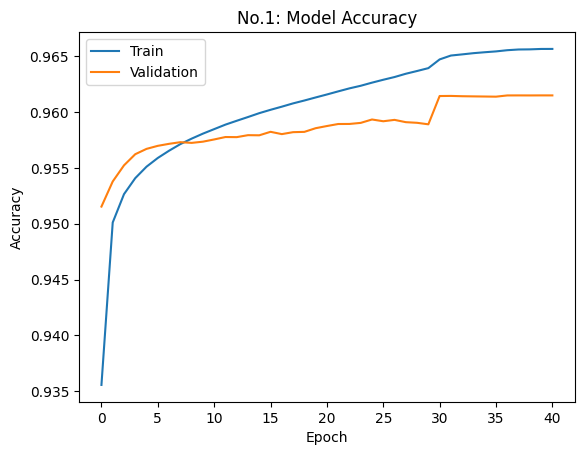

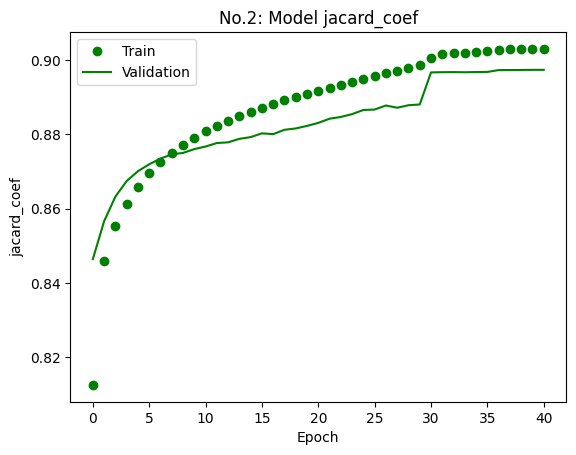

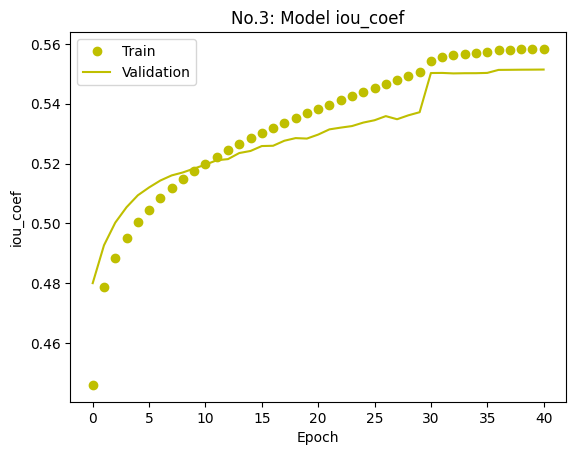

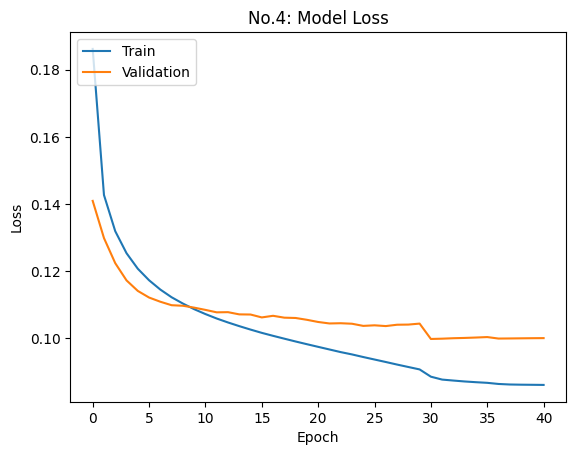

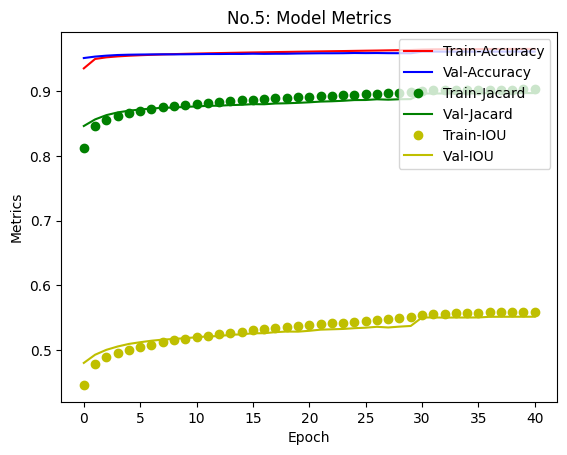

In [11]:
# =============================================================================
# plot training and Validation different metrics curves
# =============================================================================

# NO.1: Accuracy: training & validation
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('No.1: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/Accuracy.jpg",dpi=300)
plt.show()

# No.2: Jacard Coefficient: training & validation
plt.plot( history1.history['jacard_coef'], 'go', label='Training Jacard Coefficient')
plt.plot( history1.history['val_jacard_coef'], 'g', label='Validation Jacard Coefficient')
plt.title('No.2: Model jacard_coef')
plt.ylabel('jacard_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/Model jacard_coef.jpg",dpi=300)
plt.show()

# No.3: IOU Coefficient: training & validation
plt.plot( history1.history['iou_coef'], 'yo', label='Training IOU Coefficient')
plt.plot( history1.history['val_iou_coef'], 'y', label='Validation IOU Coefficient')
plt.title('No.3: Model iou_coef')
plt.ylabel('iou_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/Model iou_coef.jpg",dpi=300)
plt.show()

# No.4: loss: training & validation
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('No.4: Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/Model Loss.jpg",dpi=300)
plt.show()

# =============================================================================
# No.5: All(Accuracy, Jacard and IOU together): training & validation 

# Plot model accuracy
plt.plot(history1.history['accuracy'], 'r', label='Train-Accuracy')
plt.plot(history1.history['val_accuracy'], 'b', label='Val-Accuracy')

# Plot Jacard Coefficient and validation Jacard Coefficient
plt.plot(history1.history['jacard_coef'], 'go', label='Train-Jacard ')
plt.plot(history1.history['val_jacard_coef'], 'g', label='Val-Jacard ')

# Plot IOU Coefficient and validation IOU Coefficient
plt.plot(history1.history['iou_coef'], 'yo', label='Train-IOU ')
plt.plot(history1.history['val_iou_coef'], 'y', label='Val-IOU ')

plt.title('No.5: Model Metrics')
plt.ylabel('Metrics')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.savefig("/home/user/Desktop/MandalPaperCodePython/Results/Metrics.jpg",dpi=300)
plt.show()